# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 5 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

https://drive.google.com/open?id=1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ

In [0]:
# torch and torchvision imports
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.image_list import ImageList

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
'1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ': 'checkpoint680.pth',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


# Load Checkpoint
Here is some sample code to load the pretrained model we are providing

In [2]:
import torchvision
import torch

def pretrained_model_680(checkpoint_file):

    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    model.eval()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    backbone = model.backbone
    rpn = model.rpn
    
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    
    return backbone, rpn


backbone,rpn = pretrained_model_680('checkpoint680.pth')

# Demo of the backbones and RPN
E = torch.ones([1,3,800,1088], device='cuda')
backout = backbone(E)
print(len(backout))


from torchvision.models.detection.image_list import ImageList 
im_lis = ImageList(E, [(800,1088)])

rpn.eval()
rpnout = rpn(im_lis,backout, [{"boxes":torch.tensor([596.0027, 738.8528, 675.9938, 800.0000])}])
print(rpnout)

5
([tensor([[  0.0000,   0.0000, 109.5225,  34.7064],
        [  0.0000,   0.0000, 198.6675,  69.8575],
        [  0.0000,   0.0000, 565.8074,  58.1282],
        ...,
        [596.0027, 738.8528, 675.9938, 800.0000],
        [580.0027, 738.8528, 659.9938, 800.0000],
        [564.0027, 738.8528, 643.9938, 800.0000]], device='cuda:0')], {})


# PyTorch Dataset

Copy your HW3a dataset code

In [0]:
class HW3Dataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.path = path
        ## indicate the path for different dataset
        # imgs & mask data is h5 format
        # labels & bboxes data is npy format
        imgs_path, masks_path, labels_path, bboxes_path = self.path
        # load the data coarse data
        self.imgs_data = h5py.File(imgs_path, 'r')['data'][:]
        self.labels_data = np.load(labels_path,allow_pickle=True)
        self.masks_data = np.array(h5py.File(masks_path, 'r')['data'][:],dtype=np.float)
        self.bboxes_data = np.load(bboxes_path,allow_pickle=True)
        # assign the multiple mask to each img
        index_assign = 0
        self.mask_list = []
        for i,element in enumerate(self.labels_data):
            # how many items in this image
            item_number = len(element)
            mask_pict = self.masks_data[index_assign:index_assign+item_number,]
            self.mask_list.append(mask_pict)
            # next iteration index
            index_assign += item_number
        self.mask_list = np.array(self.mask_list)
    def __getitem__(self, index):
#         batch = {'index': index}
        img = torch.tensor(self.imgs_data[index]/255, dtype = torch.float)
        label = torch.tensor(self.labels_data[index], dtype = torch.float)
        mask = torch.tensor(self.mask_list[index],dtype = torch.float)
        bbox = torch.tensor(self.bboxes_data[index], dtype = torch.float)
        return img, label, mask, bbox
    def __len__(self):
        return len(self.imgs_data)

In [0]:

# file path and make a list
imgs_path = './hw3_mycocodata_img_comp_zlib.h5'
masks_path = './hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path,masks_path,labels_path,bboxes_path]
# load the data into data.Dataset
dataset = HW3Dataset(paths)

In [0]:
# set 80% of the dataset as the training data 
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_dataset = torch.utils.data.Subset(dataset, range(train_size))
# test_dataset = torch.utils.data.Subset(dataset, range(train_size,full_size))
# push the randomized training data into the dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)


# Resize the image, mask and bounding box

In [0]:
# This function take care of the pre-process of img,mask,bbox 
# in the input mini-batch
# img: 1*3*300*400
# mask: 1*3*300*400
# bbox: 1*n_box*4
def pre_process_batch(img, mask, bbox, target_h, target_w, pad):
    # get the ori size
    ori_h, ori_w = img.shape[2], img.shape[3]
    # compute the zoom ratio
    h_zoom_ratio, w_zoom_ratio = target_h/ori_h, target_w/ori_w
    # print(img.shape)
    ## rescale, normalize and padding the img
    # rescale to 800*1066, keep the ratio
    img = F.interpolate(img, size=[800,1066])
    # normalize the picture 
    img_squeeze = transforms.functional.normalize(img.squeeze(0), 
                                                  [0.485, 0.456, 0.406], 
                                                  [0.229, 0.224, 0.225], inplace=False)
    # add the batch back
    img = img_squeeze.unsqueeze(0)
    # padding to 800*1088
    img = F.pad(img, (pad, pad))

    ## rescale and pad the mask
    # rescale to 800*1066
    mask = F.interpolate(mask, size=[800,1066])
    # pad the mask
    mask = F.pad(mask, (pad, pad))
        
    ## rescale the bbox
    # print("-------------------")
    for i, box in enumerate(bbox.squeeze(0)):
        # get the modify the coor
        bbox[:,i,0] = bbox[:,i,0] * w_zoom_ratio + pad
        bbox[:,i,1] = bbox[:,i,1] * h_zoom_ratio
        bbox[:,i,2] = bbox[:,i,2] * w_zoom_ratio + pad
        bbox[:,i,3] = bbox[:,i,3] * h_zoom_ratio
    # print(bbox.shape)
    # print(bbox)
    # print("-------------------")
    return img, mask, bbox

# Plot the dataset (Demo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cuda:0
before the preprocess, data dimensions
img shape torch.Size([1, 3, 300, 400])
label shape torch.Size([1, 1])
label tensor([[2.]], device='cuda:0')
mask shape torch.Size([1, 1, 300, 400])
bbox shape torch.Size([1, 1, 4])
start preprocess the image...
data dimensions after preprocess
img shape torch.Size([1, 3, 800, 1088])
mask shape torch.Size([1, 1, 800, 1088])
bbox shape torch.Size([1, 1, 4])
bbox coor tensor([[[466.4984, 467.9167, 567.7684, 695.2500]]], device='cuda:0')
type of bbox <class 'torch.Tensor'>
bbox tensor([[[466.4984, 467.9167, 567.7684, 695.2500]]], device='cuda:0')
bbox_dict {'boxes': tensor([[[466.4984, 467.9167, 567.7684, 695.2500]]], device='cuda:0')}
bbox_dict type <class 'dict'>
([tensor([[469.0392, 477.5468, 557.5210, 697.0945],
        [ 96.5668, 501.5818, 932.9694, 736.9928],
        [227.1252, 595.4506, 824.0913, 751.7811],
        ...,
        [418.6291, 215.5919, 576.1124, 250.4991],
        [693.3940, 547.0301, 703.9808, 557.4772],
        [672.3165, 

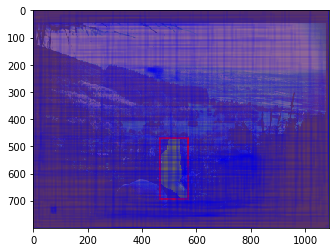

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

def plot_proposal(proposal_coor):
    x1,y1,x2,y2 = proposal_coor
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="b",facecolor='none',lw=2,alpha=0.05)
    ax.add_patch(rect)

# target h & w
target_h, target_w = 800, 1066
# pad
pad = 11
## push the img into the backbones and RPN
for i, data in enumerate(train_loader,0):
    # image pre-process
    img, label, mask, bbox = [data[i].to(device) for i in range(len(data))]
    print("before the preprocess, data dimensions")
    print('img shape',img.shape)
    print('label shape', label.shape)
    print("label", label)
    print('mask shape',mask.shape)
    print('bbox shape',bbox.shape)
    print("start preprocess the image...")
    img,mask,bbox = pre_process_batch(img,mask,bbox, target_h, target_w, pad)
    print("data dimensions after preprocess")
    print('img shape',img.shape)
    print('mask shape',mask.shape)
    print('bbox shape',bbox.shape)
    print("bbox coor", bbox)
    
    # plot the origin img
    fig, ax = plt.subplots(1)
    ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
    # plot the mask
    for i in range(mask.squeeze(0).shape[0]):
        # print("i-th mask",i)
        plt.imshow(mask.cpu().squeeze(0)[i], 'Greys', interpolation='none', alpha=0.5)
    # plot the box
    for i in range(bbox.squeeze(0).shape[0]):
        # coor of box
        x1,y1,x2,y2 = bbox.squeeze(0)[i]
        rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        ax.add_patch(rect)
    # feed the img to backbone & RPN
    backout = backbone(img)
    # prepare the data for the RPN
    im_lis = ImageList(img, [(800,1088)])

    print("type of bbox", type(bbox))
    print('bbox', bbox)
    bbox_dict = {'boxes':bbox}
    print("bbox_dict", bbox_dict)
    print("bbox_dict type", type(bbox_dict))
    rpn.eval()
    rpnout = rpn(im_lis, backout, [bbox_dict])
    print(rpnout)
    # push the rpnout into NMS first
    # print("rpnout",rpnout[0][0][0])
    # plot proposals
    ## rpnout[0][0] is the bbox tensor 
    print("RPN dimension in the rpnout",rpnout[0][0].shape)
    for proposal in rpnout[0][0]:
        # print(proposal)
        plot_proposal(proposal)
    ##plot the mask
    for mk in range(mask.squeeze(0).shape[0]):
        print(str(mk)+"-th mask shape", mask.squeeze(0)[mk,:,:].shape)
        ax.imshow(np.array(mask.squeeze(0)[mk,:,:].cpu()),alpha=0.6)
    if i == 0:
        break
# # Demo of the backbones and RPN
# E = torch.ones([1,3,800,1088], device='cuda')
# backout = backbone(E)
# print('backout lens',len(backout))

# from torchvision.models.detection.image_list import ImageList 
# im_lis = ImageList(E, [(800,1088)])

# rpn.eval()
# rpnout = rpn(im_lis,backout,[{"boxes":torch.tensor([596.0027, 738.8528, 675.9938, 800.0000])}])
# print(rpnout)
# print(len(rpnout[0][0]))

In [8]:
# Demo of the backbones and RPN
E = torch.ones([1,3,800,1088], device='cuda')
backout = backbone(E)
print('backout lens',len(backout))
print(backout.keys())
from torchvision.models.detection.image_list import ImageList 
im_lis = ImageList(E, [(800,1088)])
print("type of backout",type(backout))
print("P2 from backout shape", backout["2"].shape)
print("P1 from backout shape", backout["1"].shape)
train_featmap = {}
train_featmap["2"] = backout["2"]
print(train_featmap.keys())

rpn.eval()
rpnout = rpn(im_lis,train_featmap)
props = np.array(rpnout[0][0].cpu())
print(rpnout)
print(rpnout[0][0].shape)
print(rpnout[0][0][0,:].shape)
print(props)

backout lens 5
odict_keys(['0', '1', '2', '3', 'pool'])
type of backout <class 'collections.OrderedDict'>
P2 from backout shape torch.Size([1, 256, 50, 68])
P1 from backout shape torch.Size([1, 256, 100, 136])
dict_keys(['2'])
([tensor([[   0.0000,  767.8411,    6.8782,  800.0000],
        [1061.9812,    0.0000, 1088.0000,    3.7284],
        [1059.9321,  777.8220, 1088.0000,  791.3236],
        ...,
        [ 241.8975,  584.0415,  340.1398,  593.5680],
        [ 209.8975,  584.0415,  308.1398,  593.5680],
        [ 369.8975,  584.0415,  468.1398,  593.5680]], device='cuda:0')], {})
torch.Size([870, 4])
torch.Size([4])
[[   0.         767.84106      6.8782115  800.       ]
 [1061.9812       0.        1088.           3.72841  ]
 [1059.9321     777.822     1088.         791.3236   ]
 ...
 [ 241.89752    584.0415     340.13983    593.568    ]
 [ 209.89752    584.0415     308.13983    593.568    ]
 [ 369.89752    584.0415     468.13983    593.568    ]]


# ROI Align
ROI regularize each proposal into 7 * 7 bins.



In [9]:
## CHECKED!
# this function give the ratio split vect
def ratioSplit(bins):
    # compute the total number of splits
    n_split = (bins+1) + bins*2
    # construct the full split array
    full_split = np.linspace(0,1,n_split)
    # keep the in-bin pts
    keep_idx = (np.arange(n_split) % 3) != 0
    ratio_split = full_split[keep_idx]
    return ratio_split
# test case
ratio_split_test = ratioSplit(7)
print(ratio_split_test)

#------------------------------------------------------
## CHECKED!
## this function apply ROI Align to each proposal
# input:
    # feat_map: 1*256*50*68 (when training only P2 is used)
    # proposal coor: 4, (xyxy system)
    # h,w: the size of the ori_image 800, 1088
    # ratio_split, (n,)
# output:
    # 1 * 256 * (2*P) * (2*P)
def roiAlign(feat_map, prop_coor, h, w, ratio_split):
    # print("----------------------------------------------------")
    # print("prop_coor",prop_coor)
    # print("feat_map shape", feat_map.shape)
    feat_map = feat_map.detach().numpy()
    prop_coor = prop_coor.detach().numpy()
    # tensorize the ratio_split
    ratio_split = torch.tensor(ratio_split)
    # squeeze the feat map, get C * feat_h * feat_w
    feat_map = feat_map.squeeze(0)
    # indicate the feature map shape
    _, feat_h, feat_w = feat_map.shape
    # print("feat_h", feat_h)
    # print("feat_w", feat_w)
    # compute the zoom ratio, ratio > 1
    ratio_h, ratio_w = h/feat_h, w/feat_w
    # print("ratio_h", ratio_h)
    # print("ratio_w", ratio_w)
    # get the coor of prop in ori image
    x1,y1,x2,y2 = prop_coor
    # compute the feat_coor and its floor&ceil
    feat_x1,feat_y1,feat_x2,feat_y2 = x1/ratio_w, y1/ratio_h, x2/ratio_w, y2/ratio_h
    f_feat_x1, f_feat_y1, f_feat_x2, f_feat_y2 =  np.floor([feat_x1,feat_y1,feat_x2,feat_y2])
    c_feat_x1, c_feat_y1, c_feat_x2, c_feat_y2 = np.ceil([feat_x1,feat_y1,feat_x2,feat_y2])
    # print("feat_y1\n", feat_y1)
    # print("feat_y2\n", feat_y2)
    # print("feat_x1\n", feat_x1)
    # print("feat_x2\n", feat_x2)
    ## generate the sampling points x,y
    x = feat_x1 + (ratio_split * (feat_x2-feat_x1))
    y = feat_y1 + (ratio_split * (feat_y2-feat_y1))
    
    # generate the meshgrid and f&c meshgrid for these coors
    xx, yy = np.meshgrid(x,y)
    # print("xx",xx)
    # print("yy",yy)
    f_xx = np.floor(xx).astype(np.int)
    f_yy = np.floor(yy).astype(np.int)
    c_xx = np.ceil(xx).astype(np.int)
    c_yy = np.ceil(yy).astype(np.int)
    # get the 4 corner block matrix in the feature map
    # print("f_yy",f_yy)
    # print("f_xx",f_xx)
    # print("f_yy", f_yy)
    # print("f_xx", f_xx)
    F_fxfy = feat_map[:, f_yy, f_xx]
    F_fxcy = feat_map[:, np.minimum(c_yy, feat_h - 1), f_xx]
    F_cxfy = feat_map[:, f_yy, np.minimum(c_xx, feat_w - 1)]
    F_cxcy = feat_map[:, np.minimum(c_yy, feat_h - 1), np.minimum(c_xx, feat_w - 1)]

    # compute the bi-linear for prop in feat map
    denom = 1 / ((c_xx - f_xx)*(c_yy - f_yy))
    numer = (torch.tensor(np.abs(c_xx-xx))*F_fxfy + torch.tensor(np.abs(xx-f_xx))*F_cxfy)*torch.tensor(np.abs(c_yy-yy)) + (torch.tensor(np.abs(c_xx-xx))*F_fxcy + torch.tensor(np.abs(xx-f_xx))*F_cxcy)*torch.tensor(np.abs(yy-f_yy))
    # interploting matrix results
    prop_feat_mat = numer / denom
    # reshape the prop_feat_mat, add the batch dimension
    # print(prop_feat_mat.unsqueeze(0).shape)
    # print(prop_feat_mat)
    return prop_feat_mat.unsqueeze(0)

[0.04761905 0.0952381  0.19047619 0.23809524 0.33333333 0.38095238
 0.47619048 0.52380952 0.61904762 0.66666667 0.76190476 0.80952381
 0.9047619  0.95238095]


# Model definition

In [0]:
# this network get the output from the roiAlign function
# and do the pooling
# Input:
    # roiAlign: 1 * 256 * (2*P) * (2*P)
# output:
    # roiAlignPool: 1 * 256 * P * P
class roiAlignPool(torch.nn.Module):
    def __init__(self):
        super(roiAlignPool, self).__init__()
        # ROIAlignPool receive output from roiAlign function 
        self.avg_pool = nn.AvgPool2d(2,stride=2,padding=0)
    def forward(self, X):
        X = self.avg_pool(X)
        return X
# this network will predict the cls and reg part of the FastRCNN
# Input:
    # roiAlignPool: 1 * 256 * P * P
# output:
    # 
class FRC(torch.nn.Module):
    def __init__(self):
        super(FRC, self).__init__()
        ### two branches splits
        ## This part is for Faster-RCNN heads
        self.linear1 = nn.Linear(256*7*7, 1024)
        self.linear2 = nn.Linear(1024,1024)

        ## from the representation vecter continue to branch out
        # cls branch for the fast_RCNN
        self.linear3 = nn.Linear(1024, 4)
        # reg branch 
        self.linear4 = nn.Linear(1024, 3*4)

        ## This part is for the mask heads
    def forward(self, X):
        ## This part is for Faster-RCNN heads
        X = X.view(-1,256*7*7)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))

        # print(self.linear3(X).shape)
        ## from the representation vecter continue to branch out
        # cls branch for the fast_RCNN
        X_cls = F.softmax(self.linear3(X),dim=1)
        # reg branch for the fast_RCNN
        X_reg = self.linear4(X)
        
        return X_cls, X_reg


# not debugged
class Mask(torch.nn.Module):
    def __init__(self):
        super(Mask, self).__init__()

        self.conv_mul = nn.Conv2d(256, 256, 3, padding=1)
        self.conv_mul_bn = nn.BatchNorm2d(256)

        # this layer should double the resolution
        self.trans_conv = nn.ConvTranspose2d(256,256,4,stride=2,padding=1)
        self.trans_conv_bn = nn.BatchNorm2d(256)
        # last layer apply [1,1,4] conv
        self.conv_last = nn.Conv2d(256,4,1)
    def forward(self, X):
        # first 4 layer keep the channel number
        X = F.relu(self.conv_mul_bn(self.conv_mul(X)))
        X = F.relu(self.conv_mul_bn(self.conv_mul(X)))
        X = F.relu(self.conv_mul_bn(self.conv_mul(X)))
        X = F.relu(self.conv_mul_bn(self.conv_mul(X)))
        # 5-th layer double the size
        X = F.relu(self.trans_conv_bn(self.trans_conv(X)))
        assert X.shape[2] == 28
        # print("X shape after the deconv", X.shape)
        # the last layer
        X = F.sigmoid(self.conv_last(X))

        return X


# Uitilize functions

Here is some useful functions for futher usage.

## IoU

In [11]:
# this function will compute the IoU between one proposal and box
# xywh system
# input: 
    # prop_mat N*4
    # gt_mat M*4
# output:
    # IoU matrix: N*M
def IoU(prop_mat, gt_mat):
    if prop_mat.shape == (4,):
        prop_mat = prop_mat.reshape(1,-1)
    if gt_mat.shape == (4,):
        gt_mat = gt_mat.reshape(1,-1)
    
    # compute the range of the anchor box
    x_p_min = (prop_mat[:,0] - prop_mat[:,2]/2).reshape(-1,1)
    x_p_max = (prop_mat[:,0] + prop_mat[:,2]/2).reshape(-1,1)
    # print("x_p_max",x_p_max)
    y_p_min = (prop_mat[:,1] - prop_mat[:,3]/2).reshape(-1,1)
    y_p_max = (prop_mat[:,1] + prop_mat[:,3]/2).reshape(-1,1)
    # compute the anchor area
    area_p = (prop_mat[:,2] * prop_mat[:,3]).reshape(-1,1)
    # print("x_p_max",x_p_max)
    # print("area_p",area_p)
    # compute the range of the gt bounding box
    x_gt_min = (gt_mat[:,0] - gt_mat[:,2]/2).reshape(-1,1)
    x_gt_max = (gt_mat[:,0] + gt_mat[:,2]/2).reshape(-1,1)
    y_gt_min = (gt_mat[:,1] - gt_mat[:,3]/2).reshape(-1,1)
    y_gt_max = (gt_mat[:,1] + gt_mat[:,3]/2).reshape(-1,1)
    # compute the gt area
    area_gt = (gt_mat[:,2] * gt_mat[:,3]).reshape(-1,1)
    # print("x_gt_max",x_gt_max)
    # print("area_gt",area_gt)
    # print("x_p_max.shape[0]", x_p_max.shape[0])
    # assert x_p_max.shape[0] > 1
    # print("np.minimum(x_p_max, x_gt_max.T)\n",np.minimum(x_p_max, x_gt_max.T))
    # print("x_p_min",x_p_min)
    # print("x_gt_min",x_gt_min)
    # print("np.maximum(x_p_min, x_gt_min.T",np.maximum(x_p_min, x_gt_min.T))
    # print("np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T\n",
    #       np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T))
    # print("np.maximum(np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T), 0)\n",
    #       np.maximum(np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T), 0))
    
    # compute the intersect w & h
    intersect_p_gt_w = np.maximum(np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T), 0)
    
    intersect_p_gt_h = np.maximum(np.minimum(y_p_max, y_gt_max.T) - np.maximum(y_p_min, y_gt_min.T), 0)
    # compute intersect area
    area_intersect = intersect_p_gt_w * intersect_p_gt_h
    # print("area_intersect",area_intersect)
    # compute union area
    area_union = (area_p + area_gt.T) - area_intersect
    # print("area_union",area_union)
    # print(area_intersect)
    # print(area_union)
    IoU = area_intersect / area_union
    # print("IoU",IoU)
    # print("----------------------------")
    return IoU
    
# this function change the x1y1x2y2 system to xywh system
def xyxyToxywh(coor):
    return (coor[0]+coor[2])/2, (coor[1]+coor[3])/2, coor[2]-coor[0], coor[3]-coor[1]

def xywhToxyxy(coor):
    return coor[0]-coor[2]/2, coor[1]-coor[3]/2, coor[0]+coor[2]/2, coor[1]+coor[3]/2

def refineCompute(prop_x, prop_y, prop_w, prop_h, gt_x, gt_y, gt_w, gt_h):
    t_x = (gt_x - prop_x) / prop_w
    t_y = (gt_y - prop_y) / prop_h
    t_w = np.log(gt_w / prop_w)
    t_h = np.log(gt_h / prop_h)
    return t_x, t_y, t_w, t_h
def refineRecover(prop_x, prop_y, prop_w, prop_h, t_x, t_y, t_w, t_h):
    x = t_x*prop_w + prop_x
    y = t_y*prop_h + prop_y
    w = prop_w * torch.exp(t_w)
    h = prop_h * torch.exp(t_h)
    return x,y,w,h
# this function will pre-process the proposals
# i.e. will subsample the proposal for the training use
def propSubSample(sample_num, p_n_list, seed=0):
    # print("subsampling...")
    sample_num = torch.tensor(sample_num)
    # set the seed for the random sampling
    np.random.seed(seed)

    # idx the T/F list
    idx = torch.arange(len(p_n_list))
    
    # pos number & neg number
    # pos_num = torch.min(torch.sum(p_n_list), sample_num/4)
    # neg_num = pos_num * 3
    pos_num = torch.min(torch.sum(p_n_list), sample_num*3/4)
    neg_num = pos_num / 3
    # print("Exist pos num", pos_num)
    # print("Exist neg num", neg_num)
    
    # print("idx shape", idx.shape)
    # pos_idx & neg_idx
    pos_idx = idx[p_n_list]
    neg_idx = idx[~p_n_list]

    # print("pos idx", pos_idx)
    # print("neg idx", neg_idx)
    # print(torch.sum(p_n_list))
    # print(sample_num/4)
    # subsampling
    pos_sub = np.random.choice(pos_idx, np.array(pos_num), replace=False)
    neg_sub = np.random.choice(neg_idx, np.array(neg_num), replace=False)
    sub_sampling = np.concatenate((pos_sub,neg_sub))
    # print(np.sort(sub_sampling))
    # print("Total subsampling proposals:", len(sub_sampling))
    
    return np.sort(sub_sampling)

# test for IoU
print("test for IoU---------------------")
prop_mat = torch.tensor([[2,0,4,4]],dtype = torch.float)

gt_mat = torch.tensor([[0,0,4,4]],dtype = torch.float)
IoU_matrix = IoU(prop_mat,gt_mat)

print("IoU_matrix",IoU_matrix)

val, idx = torch.max(IoU_matrix, axis=1)
print("val", val)
print("idx", idx)
# prop_max_idx = torch.argmax(IoU_matrix, axis=1)


# print(prop_max_IoU)
# print("prop_max_idx",prop_max_idx)
# print("prop_max_IoU",IoU_matrix[prop_max_idx])
# print(prop_max_IoU>0.2)
print(val > 0.2)
print(prop_mat[val > 0.2])
if IoU_matrix>0.3:
    print("test pass")
# print(len(prop_max_IoU))
print("---------------------------------")

test for IoU---------------------
IoU_matrix tensor([[0.3333]])
val tensor([0.3333])
idx tensor([0])
tensor([True])
tensor([[2., 0., 4., 4.]])
test pass
---------------------------------


## FRCNMS

In [0]:
## this function is FRC_NMS
def FRCNMS(output_FRC_cls, output_FRC_reg, subsample_idx, train_props_idx, props, IoU_thresh,h,w):
    
    # change the idx which is torch.int to torch.float for torch.cat
    train_props_idx = torch.tensor(train_props_idx, dtype=torch.float)
    subsample_idx = torch.tensor(subsample_idx, dtype=torch.float)
    # print("train_props_idx.dtype", train_props_idx.dtype)
    # print("output_FRC_cls.dtype", output_FRC_cls.dtype)
    # print("output_FRC_reg.dtype", output_FRC_reg.dtype)
    # print("subsample_idx.dtype", subsample_idx.dtype)
# Input:
    # output_FRC_cls: (n_FRC_train, 4)
    # output_FRC_reg: (n_FRC_train, 12)
    # subsample_idx(This links prop to gt_box): (n_FRC_train,)
    # train_props_idx(This links prop to its idx in ori props): (n_FRC_train,)
    # props(this is ori proposals): (N_RPN, 4)
# Output:
    # FRC_nms: (D, 5) (1cls+4coor(real_xyxy)) 4 coor is in the ori_img
    # detect_gt_idx(This links detects to gt_box): (D, )w
    
    ###----------------------------------------------------
    ## extract the objectness and cls label for each detection
    pred_obj, pred_cls = torch.max(output_FRC_cls, axis=1)
    ## divide the detection into 3 cluster.
    # find clust idx first
    clust_idx_1 = pred_cls==1
    clust_idx_2 = pred_cls==2
    clust_idx_3 = pred_cls==3
    n_clust_1 = torch.sum(clust_idx_1)
    n_clust_2 = torch.sum(clust_idx_2)
    n_clust_3 = torch.sum(clust_idx_3)
    if (n_clust_1 + n_clust_2 + n_clust_3) == 0:
        return None, None, False
        
    # print("type of clust_idx_1", type(clust_idx_1))
    # print("clust_idx_1", clust_idx_1)
    # print("pred_cls==1 number", torch.sum(clust_idx_1))
    # print("pred_cls==2 number", torch.sum(clust_idx_2))
    # print("pred_cls==3 number", torch.sum(clust_idx_3))
    # construct the NMS_clust: (Di, 7)
    # print("pred_obj[clust_idx_1].reshape(-1,1)", pred_obj[clust_idx_1].reshape(-1,1))
    # print("output_FRC_reg[clust_idx_1][:,0:4]", output_FRC_reg[clust_idx_1][:,0:4])
    # print("type of train_props_idx", type(train_props_idx))
    # print("train_props_idx[clust_idx_1].reshape(-1,1)", train_props_idx[clust_idx_1].reshape(-1,1))
    
    NMS_clust_1 = torch.cat((pred_obj[clust_idx_1].reshape(-1,1),
                             output_FRC_reg[clust_idx_1][:,0:4],
                             subsample_idx[clust_idx_1].reshape(-1,1),
                             train_props_idx[clust_idx_1].reshape(-1,1)), 1)
    # print("NMS_clust_1.shape", NMS_clust_1.shape)
    # print("len(clust_idx_1)", len(clust_idx_1))
    # print("torch.sum(clust_idx_1)", torch.sum(clust_idx_1))
    assert NMS_clust_1.shape == (torch.sum(clust_idx_1), 7)

    # print("NMS_clust_1 shape", NMS_clust_1.shape)

    NMS_clust_2 = torch.cat((pred_obj[clust_idx_2].reshape(-1,1),
                             output_FRC_reg[clust_idx_2][:,4:8],
                             subsample_idx[clust_idx_2].reshape(-1,1),
                             train_props_idx[clust_idx_2].reshape(-1,1)), 1)
    assert NMS_clust_2.shape == (torch.sum(clust_idx_2), 7)

    # print("NMS_clust_2 shape", NMS_clust_2.shape)

    NMS_clust_3 = torch.cat((pred_obj[clust_idx_3].reshape(-1,1),
                             output_FRC_reg[clust_idx_3][:,8:12],
                             subsample_idx[clust_idx_3].reshape(-1,1),
                             train_props_idx[clust_idx_3].reshape(-1,1)), 1)
    assert NMS_clust_3.shape == (torch.sum(clust_idx_3), 7)

    # print("NMS_clust_3 shape", NMS_clust_3.shape)

    # print("non-background detections number", n_clust_1+n_clust_2+n_clust_3)

    # for each of these clust, do NMS and output the (Di, 7) as the filtered detection coor
    FRC_nms_list = []
    if n_clust_1>0:
        FRC_nms_1 = ClustNMS(NMS_clust_1, props, 1, IoU_thresh,h,w)
        FRC_nms_list.append(FRC_nms_1)
        # print("FRC_nms_1 shape", FRC_nms_1.shape)
        assert FRC_nms_1.shape[1] == 7
    if n_clust_2>0:
        FRC_nms_2 = ClustNMS(NMS_clust_2, props, 2, IoU_thresh,h,w)
        FRC_nms_list.append(FRC_nms_2)
        assert FRC_nms_2.shape[1] == 7
    if n_clust_3>0:
        FRC_nms_3 = ClustNMS(NMS_clust_3, props, 3, IoU_thresh,h,w)
        FRC_nms_list.append(FRC_nms_3)
        assert FRC_nms_3.shape[1] == 7

    # FRC_nms: (Di_filter, 7) (1cls+1obj+4coor+1box_idx)
    for FRC_nms_idx, FRC_nms_i in enumerate(FRC_nms_list):
        if FRC_nms_idx==0:
            FRC_nms = FRC_nms_i
        else:
            FRC_nms = torch.cat((FRC_nms, FRC_nms_i), 0)
    if FRC_nms.shape[0] == 0:
        return None, None, False
    # print("FRC_nms shape", FRC_nms.shape)
    # cut the FRC within 100 rows
    if len(FRC_nms) > 100:
        objness_vect = FRC_nms[:,1]
        sorted, indices = torch.sort(objness_vect, 0, descending=True)
        FRC_nms = FRC_nms[indices][:100,:]

    # get the last col as the detect_gt_idx
    detect_gt_idx = FRC_nms[:,6].type(torch.int)
    # only need the obj and coor part of the matrix
    FRC_nms = torch.cat((FRC_nms[:,0].reshape(-1,1),FRC_nms[:,2:6]), 1)
    
    assert FRC_nms.shape == (len(FRC_nms),5)
    assert detect_gt_idx.shape == (len(FRC_nms),)
    return FRC_nms, detect_gt_idx, True

def ClustNMS(NMS_clust, props, cls, IoU_thresh,h,w):
# Input:
    # NMS_clust: (Di, 7) (1obj+4reg+1box_idx+1prop_idx)
# Output:
    # FRC_nms: (Di_filter, 7) (1cls+1obj+4coor(real_xyxy)+1box_idx)
    ###-------------------------------------------------
    ## dimension indicator
    D, _ = NMS_clust.shape
    ## get the objectness
    obj_vect = NMS_clust[:,0]
    # print("obj_vect shape", obj_vect.shape)
    assert obj_vect.shape == (D,)
    sorted, sort_indices = torch.sort(obj_vect, 0, descending=True)
    ## sort the NMS_clust according to the objectness
    sorted_NMS_clust = NMS_clust[sort_indices]

    # FRC_nms = torch.zeros((D, 7))
    # fill the first col
    # FRC_nms[:,0] = cls
    rows = []
    # # init the rows
    # prop_idx = sorted_NMS_clust[0,6].type(torch.int)
    # # print("prop_idx dtype", prop_idx.dtype)
    # prop_x, prop_y, prop_w, prop_h = xyxyToxywh(props[prop_idx])
    # t_x, t_y, t_w, t_h = sorted_NMS_clust[0,1:5]
    # refed_x, refed_y, refed_w, refed_h = refineRecover(prop_x, prop_y, prop_w, prop_h, t_x, t_y, t_w, t_h)
    # refed_x1, refed_y1, refed_x2, refed_y2 = xywhToxyxy([refed_x, refed_y, refed_w, refed_h])
    # obj_val = sorted_NMS_clust[0,0]
    # box_id = sorted_NMS_clust[0,5]
    # rows.append(torch.tensor([cls, obj_val, refed_x1, refed_y1, refed_x2, refed_y2, box_id]))
    ## for loop NMS process
    for i in range(D):
        survive = True
        prop_idx = sorted_NMS_clust[i,6].type(torch.int)
        # print(prop_idx.dtype)
        prop_x, prop_y, prop_w, prop_h = xyxyToxywh(props[prop_idx])
        t_x, t_y, t_w, t_h = sorted_NMS_clust[i,1:5]
        refed_x, refed_y, refed_w, refed_h = refineRecover(prop_x, prop_y, prop_w, prop_h, t_x, t_y, t_w, t_h)
        refed_x1, refed_y1, refed_x2, refed_y2 = xywhToxyxy([refed_x, refed_y, refed_w, refed_h])
        # cross-boundary judge
        if refed_x1<0 or refed_y1<0 or refed_x2>w or refed_y2>h:
            continue
        obj_val = sorted_NMS_clust[i,0]
        box_id = sorted_NMS_clust[i,5]
        # if rows list is empty, append to the list directly
        if len(rows) == 0:
            rows.append(torch.tensor([cls, obj_val, refed_x1, refed_y1, refed_x2, refed_y2, box_id]))
            continue
        for detection in rows:
            prev_x, prev_y, prev_w, prev_h = detection[2:6]
            loop_IoU = IoU(torch.tensor([[prev_x, prev_y, prev_w, prev_h]]), torch.tensor([[refed_x, refed_y, refed_w, refed_h]]))
            if loop_IoU >= IoU_thresh:
                survive = False
                break
        # if the detection survive the NMS, put it into rows list
        if survive == True:
            rows.append(torch.tensor([cls, obj_val, refed_x1, refed_y1, refed_x2, refed_y2, box_id]))
    
    # construct the output of this function
    FRC_nms = torch.zeros((len(rows), 7))
    for row_idx, row in enumerate(rows):
        FRC_nms[row_idx,:] = row
    
    return FRC_nms
                


# def 

## Decoder

In [0]:
## this function decode the fastRCNN prediction
# Input: 
    # props: n_prop * 4 (contain the coor info )
    # pred_matrix: n_prop * 16 (xywh refine system)
# Output: this function plot the refined box and its class
def FRCDecoder(props, FRC_pred_matrix):
    # print("pred_matrix",pred_matrix)
    # number of proposals
    n_prop = props.shape[0]
    # cols for classes and refine
    cols_cls = FRC_pred_matrix[:,:4]


    #------------------------
    #only for demo
    # cols_cls[:,1:] +=0.2
    #------------------------


    # indicate the label for each row
    _, cls = torch.max(cols_cls, axis=1)
    # print("cls in FRCDecode", cls)
    # print("In FRCDecode function, cls shape", cls.shape)
    assert cls.shape == (n_prop,)
    cols_refine = FRC_pred_matrix[:,4:]
    
    print("cls in FRCdecoder", cls)
    # color_list
    clr_list = ["b",'g','y']
    # print("FRC before NMS location record-----------------------------")
    # plot the props row by row
    for i in range(n_prop):
        
        # print("type cls[i]", type(cls[i]))
        cls_i = cls[i].type(torch.int)
        # print("cls_i", cls_i)
        
        
        if cls_i != 0:
            clr = clr_list[cls_i - 1]
            # print("clr",clr)
            prop_x, prop_y, prop_w, prop_h = xyxyToxywh(props[i])
            # print("cols_refine",cols_refine)
            t_x, t_y, t_w, t_h = cols_refine[i,(cls_i-1)*4:(cls_i)*4]
            # compute the refined coor
            fin_x = t_x * prop_w + prop_x
            fin_y = t_y * prop_h + prop_y
            fin_w = prop_w * torch.exp(t_w)
            fin_h = prop_h * torch.exp(t_h)
            # print("plot coor", fin_x-fin_w/2, fin_y-fin_h/2, fin_x+fin_w/2, fin_y+fin_h/2)
            rect = patches.Rectangle((fin_x-fin_w/2, fin_y-fin_h/2), fin_w, fin_h,linewidth=1, edgecolor=clr, facecolor='none', lw=2)
            ax.add_patch(rect)
            # print(fin_x,fin_y,fin_w,fin_h)
    # print("location record end---------------------------------------")            
    pass
## this function decode the fastRCNN prediction
# Input: 
    # props: n_prop * 4 (contain the coor info )
    # pred_matrix: n_prop * 13 (xywh refine system)
# Output: this function plot the refined box and its class
def FRCGTDecoder(props, FRC_gt_matrix):
    # print("pred_matrix",pred_matrix)
    # number of proposals
    n_prop = props.shape[0]
    # cols for classes and refine
    cls = FRC_gt_matrix[:,0]
    # print("cls in FRCDecode", cls)
    # print("In FRCDecode function, cls shape", cls.shape)
    assert cls.shape == (n_prop,)
    cols_refine = FRC_gt_matrix[:,1:]
    # indicate the label for each row and its probability
    # cls_val, cls = torch.max(cols_cls, axis=1)
    # color_list
    clr_list = ["b",'g','y']
    # plot the props row by row
    # print("FRC before NMS location record-----------------------------")
    for i in range(n_prop):
        
        # print("type cls[i]", type(cls[i]))
        cls_i = cls[i].type(torch.int)
        # print("cls_i", cls_i)
        
        
        if cls_i != 0:
            clr = clr_list[cls_i - 1]
            # print("clr",clr)
            prop_x, prop_y, prop_w, prop_h = xyxyToxywh(props[i])
            # print("cols_refine",cols_refine)
            t_x, t_y, t_w, t_h = cols_refine[i,(cls_i-1)*4:(cls_i)*4]
            # compute the refined coor
            fin_x = t_x * prop_w + prop_x
            fin_y = t_y * prop_h + prop_y
            fin_w = prop_w * np.exp(t_w)
            fin_h = prop_h * np.exp(t_h)
            # print("plot coor", fin_x-fin_w/2, fin_y-fin_h/2, fin_x+fin_w/2, fin_y+fin_h/2)
            rect = patches.Rectangle((fin_x-fin_w/2, fin_y-fin_h/2), fin_w, fin_h,linewidth=1, edgecolor=clr, facecolor='none', lw=2)
            ax.add_patch(rect)
            # print(fin_x,fin_y,fin_w,fin_h)
    # print("location record end---------------------------------------")
    pass

## this function decode the fastRCNN prediction
# Input: 
    # FRC_NMS_matrix: n_detect * 5 (xyxy system)
# Output: this function plot the refined box and its class
def FRCNMSDecoder(FRC_NMS_matrix):
    # print("pred_matrix",pred_matrix)
    # number of detections
    n_detect = FRC_NMS_matrix.shape[0]
    # cols of class
    cls = FRC_NMS_matrix[:,0]
    assert cls.shape == (n_detect,)

    cols_coor = FRC_NMS_matrix[:,1:]
    
    # print("cls in FRCdecoder", cls)
    # color_list
    clr_list = ["b",'g','y']
    # plot the props row by row
    for i in range(n_detect):
        
        # print("type cls[i]", type(cls[i]))
        cls_i = cls[i].type(torch.int)
        # print("cls_i", cls_i)
        
        
        if cls_i != 0:
            clr = clr_list[cls_i - 1]            
            
            x1, y1, x2, y2 = cols_coor[i,:]
            
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,linewidth=1, edgecolor=clr, facecolor='none', lw=2)
            ax.add_patch(rect)
    pass

## loss functions definition

In [0]:
## Loss function
def FRCLoss(FRC_gt, output_FRC_cls, output_FRC_reg, lambda_reg):
    # init reg loss
    reg_loss = 0
    N_reg = 0
    # indicate the number of proposals
    n_props,_ = FRC_gt.shape
    # extract out the cls and reg information
    # cls_gt: (N,)
    cls_gt = FRC_gt[:,0]
    reg_gt = FRC_gt[:,1:]
    assert cls_gt.shape == (n_props,)
    assert reg_gt.shape == (n_props, 12)
    ## compute the CrossEntropyLoss
    CELoss = nn.CrossEntropyLoss()
    cls_loss = CELoss(output_FRC_cls.type(torch.float), cls_gt.type(torch.long))
    # print("output_FRC_cls.type(torch.float)",output_FRC_cls.type(torch.float))
    # print("cls_gt.type(torch.long)",cls_gt.type(torch.long))
    N_cls = n_props
    ## compute the L1 loss
    # define the smooth function L1
    smooth_L1 = lambda x: 0.5*x**2 if torch.abs(x)<=1 else torch.abs(x)-0.5
    for i in range(n_props):
        if cls_gt[i] != 0:
            N_reg += 4
            for k in range(reg_gt.shape[1]):
                diff_t = output_FRC_reg[i,k] - reg_gt[i, k]
                reg_loss += smooth_L1(diff_t)
    # finialize the loss
    absent = True if N_cls == 0 and N_reg == 0 else False
    ret_reg_loss = 0 if N_reg == 0 else reg_loss/N_reg
    ret_cls_loss = 0 if N_cls == 0 else cls_loss/N_cls
    # sum two part of the loss
    total_loss = ret_cls_loss + lambda_reg * ret_reg_loss
    return total_loss, ret_cls_loss, ret_reg_loss, absent

## this function is for the mask loss function
# input: 
    # gt_mask: (D,28,28)
    # mask_pred: (D,4,28,28)
    # detect_cls: (D,)
# output:
    # mask_loss: scalar
def MaskLoss(gt_mask, mask_pred, detect_cls):
    mask_loss = 0
    n_detect = mask_pred.shape[0]
    m = mask_pred.shape[2]
    assert detect_cls.shape == (n_detect,)
    # define the loss function
    BCELoss = nn.BCELoss()
    # go through the n_detect masks.
    for i in range(n_detect):
        cls_i = detect_cls[i].type(torch.int)
        pred_mask_i = mask_pred[i,cls_i,:,:]
        gt_mask_i = gt_mask[i]
        mask_loss += BCELoss(pred_mask_i.type(torch.float), gt_mask_i.type(torch.float))
    return mask_loss

# Train the model

## Training

In [0]:
# Training
# saving
# from google.colab import files
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# target h & w
target_h, target_w = 800, 1066
# pad
pad = 11
# bg/fg threshold
bf_thresh = 0.5
# IoU thresh in the NMS
IoU_thresh = 0.5
# mask thresh
mask_thresh = 0.5
# subsampling number
sample_num = 128
# roiAlign bins for FRC
bins_FRC = 7
# roiAlign bins for Mask
bins_Mask = 14
bins_gt_Mask = 28
# the preprocessed img size
h, w = 800, 1088

## net information
# net initialization
roi_net = roiAlignPool()
roi_net = roi_net.float()
FRC_net = FRC()
FRC_net = FRC_net.float()
Mask_net = Mask()
Mask_net = Mask_net.float()
# optimizer = optim.Adam(FRC_net.parameters(), lr=0.001) # for test

# optimizer
paras = list(roi_net.parameters()) + list(FRC_net.parameters()) + list(Mask_net.parameters())
optimizer = optim.Adam(paras, lr=0.001)


runing_total_loss = 0
runing_FRC_cls_loss = 0
runing_FRC_reg_loss = 0
runing_mask_loss = 0

traning_total_loss = []
traning_FRC_cls_loss = []
traning_FRC_reg_loss = []
traning_mask_loss = []

lambda_reg = 1/10
lambda_mask = 1/1000
record_step=1
num_epochs = 30
epoch = 0

while epoch < num_epochs:
    ## push the img into the backbones and RPN
    for iters, data in enumerate(train_loader,0):
        # Read the dataloader
        img, label, mask, bbox = [data[i].to(device) for i in range(len(data))]
        # image pre-process
        img, mask, bbox = pre_process_batch(img,mask,bbox, target_h, target_w, pad)
        # print("mask.shape", mask.shape)
        # print("mask",mask[:,0,:,:].shape)
        '''
        # plot the origin img
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)
        '''
        
        # push the data into backbone
        backout = backbone(img)
        im_lis = ImageList(img, [(800,1088)])
        # only use the P2 from the feature map in the training
        train_featmap = {}
        train_featmap["2"] = backout["2"]
        # print("train feat map dict val", train_featmap["2"].shape)
        # push the feature map into the RPN model and get rpn as proposals
        # here I use all the FPN as the feature map in order to give the best proposal
        # if only give the P2, some close object will not be proposed
        # rpnout: 
        rpn.eval()
        rpnout = rpn(im_lis, backout)
        props = rpnout[0][0]

        '''
        for proposal in rpnout[0][0]:
        # print(proposal)
            plot_proposal(proposal)
        # print(props.shape)
        '''
        
        # print("bbox shape", bbox.shape)
        # print("bbox squeeze shape", bbox.squeeze(0).shape)
        # print("bbox squeeze", bbox.squeeze(0)[0])
        # print(props.cpu().dtype)
        # print(bbox.squeeze(0).cpu().dtype)
        # print(np.array(props.cpu()).shape)
        # bbox_sqz = 
        # IoU_matrix = IoU(np.array(props.cpu()),np.array(bbox.squeeze(0).cpu()))
        # print(IoU_matrix)

        # print("------------------------------")
        assert props.cpu().dtype == torch.float
        assert bbox.squeeze(0).cpu().dtype == torch.float
        IoU_matrix = IoU(props.cpu(),bbox.squeeze(0).cpu())
        # print("IoU_matrix shape", IoU_matrix.shape)
        # compute the max val and its idx for each row
        val, idx = torch.max(IoU_matrix, axis=1)
        # print("idx shape", idx.shape)
        #coarse label each prop
        prop_labels = label.T[idx]

        # filter out the background, set the label for the bg as 0.
        bg_filter = val < bf_thresh
        prop_labels[bg_filter] = 0

        # print("negtive number", torch.sum(bg_filter))

        ## train_props_idx is used to trace back the proposals
        ## this part of index is for first filter out training subsamples for FRC training
        train_props_idx = propSubSample(sample_num, ~bg_filter)
        # print("total label shape",prop_labels.shape)
        # print("total proposal shape", props.shape)
        # print("lens of train_props_idx", len(train_props_idx))
        # print("train_props_idx", train_props_idx)
        subsample_props = props[train_props_idx]
        subsample_labels = prop_labels[train_props_idx]
        subsample_idx = idx[train_props_idx]
        # print("sub label shape",subsample_labels.shape)
        # print("sub proposal shape", subsample_props.shape)
        # print(subsample_props[0])

        
        ### assemble the data for the training
        #-----------------------------------------------------------------
        # remember subsample_idx keeps the info: which proposal link to which gt box
        n_FRC_train = subsample_props.shape[0]
        ## construct Input to FastRCNN
        # print("FRC input construct---------------------------")
        inputs_FRC = torch.zeros((n_FRC_train, 256, bins_FRC*2, bins_FRC*2))
        # compute ratio_split_FRC
        ratio_split_FRC = ratioSplit(bins_FRC)
        for i, prop in enumerate(subsample_props):
            inputs_FRC[i,:,:,:] = roiAlign(train_featmap["2"].cpu(), prop.cpu(), 800, 1088, ratio_split_FRC)
        # print("train_featmap shape",train_featmap["2"].shape)
        assert inputs_FRC.shape == (n_FRC_train, 256, bins_FRC*2, bins_FRC*2)
        ## and gt matrix for FRC training
        ## FRC_gt: [n_FRC_train * 16]. 13=1(cls)+3(#cls num)*4()
        # FRC_gt = torch.zeros((n_FRC_train, 13))
        # print("FRC gt construct---------------------------")
        FRC_gt = torch.zeros((n_FRC_train, 13))
        # indicate the label for each subprops
        # print("FRC_gt",FRC_gt)
        # print("subsample_labels",subsample_labels)
        FRC_gt[:,0] = subsample_labels.T
        for i in range(n_FRC_train):
            
            # print("Start fill FRC_gt\n---------------------------------------------------------------------")
            # fill in the cls info
            # print("subsample_labels[i]",np.array(subsample_labels[i].cpu(),dtype=np.int))
            # print("cls_i", cls_i)
            # FRC_gt[i, cls_i] = 1
            # FRC_gt[:,0] = subsample_labels

            ## fill in the refinement info only if the cls != 0
            ## indicate the cls
            cls_i = np.array(subsample_labels[i].cpu(),dtype=np.int)
            if cls_i != 0:
                box_idx = subsample_idx[i]
                # print("box_idx", box_idx)
                prop_x, prop_y, prop_w, prop_h = xyxyToxywh(subsample_props[i].cpu())
                gt_x, gt_y, gt_w, gt_h = xyxyToxywh(bbox.squeeze(0)[box_idx].cpu())
                t_x, t_y, t_w, t_h = refineCompute(prop_x, prop_y, prop_w, prop_h, gt_x, gt_y, gt_w, gt_h)
                start_fill = np.array((1 + (subsample_labels[i].cpu()-1) * 4), dtype=np.int)
                # print("label", idx[i])
                # print("t_x, t_y, t_w, t_h",t_x, t_y, t_w, t_h)
                FRC_gt[i, start_fill] = t_x
                FRC_gt[i, start_fill+1] = t_y
                FRC_gt[i, start_fill+2] = t_w
                FRC_gt[i, start_fill+3] = t_h
            # print("---------------------------------------------------------------------")
        '''
        # decode gt_matrix to test
        # print("label in FRC_gt", FRC_gt[:,0])
        print("FRC gt decode---------------------------")
        FRCGTDecoder(subsample_props, FRC_gt)
        plt.show()
        '''
        
        ###----------------------------------------------------------------
        ### forward in the FRC
        # print("FRC forward---------------------------")
        
        ## First pass projected ROI to a ROIAlign via a feature map
        output_roiAlign = roi_net(inputs_FRC)
        assert output_roiAlign.shape == (n_FRC_train, 256, 7, 7)
        # print("n_FRC_train", n_FRC_train)

        ## Second pass ROIAlign result into the FRC network
        ## get the predicted matrix: n_FRC_train * 16
        ## and the track_back gt_box idx 
        output_FRC_cls, output_FRC_reg = FRC_net(output_roiAlign)
        assert output_FRC_cls.shape == (n_FRC_train, 4)
        assert output_FRC_reg.shape == (n_FRC_train, 12)
        # print("shape of output_FRC_cls",output_FRC_cls.shape)
        # print("shape of output_FRC_reg",output_FRC_reg.shape)
        FRC_total_loss, FRC_cls_loss, FRC_reg_loss, absent = FRCLoss(FRC_gt, output_FRC_cls, output_FRC_reg, lambda_reg)
        
        # assert output_FRC_cls.shape == (n_FRC_train, 4)
        # assert output_FRC_reg.shape == (n_FRC_train, 12)

        '''
        ## For demo, plot the output_FRC detections
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)
        

        output_FRC_cls_demo = output_FRC_cls.clone()
        # output_FRC_cls_demo[:,1:] += 0.2
        FRC_output_combine = torch.cat((output_FRC_cls_demo, output_FRC_reg), 1)
        FRCDecoder(subsample_props, FRC_output_combine)
        plt.show()
        '''

        ###------------------------------------------------------------
        # from this below, not debugged...............
        # print("Mask part---------------------------")
        # print("From this point no debug...")
        ## after the FRC prediction, post processing.
        # FRC_nms: (D, 5) (1cls+4coor) 4 coor is in the ori_img
        # detect_gt_idx(This links detects to gt_box): (D, )
         
        # FRCNMS not debugged
        # FRC_nms: (D, 5) (1cls+4coor) 4 coor is in the ori_img
        # detect_gt_idx(This links detects to gt_box): (D, )
        FRC_nms, detect_gt_idx, exist = FRCNMS(output_FRC_cls, output_FRC_reg, subsample_idx, train_props_idx, props, IoU_thresh,800,1088)
        if exist == False:
            continue
        # print("FRC_nms\n",FRC_nms)
        # print("FRC_NMS output\n", FRC_nms)
        '''
        ##For demo, plot the detections after NMS
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)

        FRCNMSDecoder(FRC_nms)
        
        plt.show()
        '''
        # print("FRC_nms\n",FRC_nms)
        
        n_detect = len(FRC_nms)
        ## construct Input to MaskNet
        inputs_Mask = torch.zeros((n_detect, 256, bins_Mask*2, bins_Mask*2))
        # compute ratio_split_Mask
        ratio_split_Mask = ratioSplit(bins_Mask)
        for i, cls_coor in enumerate(FRC_nms):
            # gt_mask_idx = detect_gt_idx[i]
            detect_coor = cls_coor[1:]
            assert detect_coor.shape == (4,)
            inputs_Mask[i,:,:,:] = roiAlign(train_featmap["2"].cpu(), detect_coor, 800, 1088, ratio_split_Mask)
        # print("train_featmap shape",train_featmap["2"].shape)
        assert inputs_Mask.shape == (n_detect, 256, bins_Mask*2, bins_Mask*2)
        

        ## construct gt for the mask: (D*28*28)
        # gt_mask: (D*28*28)
        # compute ratio_split_FRC
        
        gt_mask_roi_sample = torch.zeros((n_detect, 56, 56))
        ratio_split_gt_Mask = ratioSplit(bins_gt_Mask)
        for i, cls_coor in enumerate(FRC_nms):
            gt_mask_idx = detect_gt_idx[i]
            detect_coor = cls_coor[1:]
            assert detect_coor.shape == (4,)
            mask_into_roiAlign = mask[:,gt_mask_idx,:,:].unsqueeze(0)
            assert mask_into_roiAlign.shape == (1,1,800,1088)
            mask_roiAlign = roiAlign(mask_into_roiAlign.cpu(), detect_coor, 800, 1088, ratio_split_gt_Mask)
            assert mask_roiAlign.shape == (1,1,56,56)
            gt_mask_roi_sample[i, :, :] = mask_roiAlign.squeeze()
        
        # push the gt_mask_sample into the roiAlignPool
        gt_mask = roi_net(gt_mask_roi_sample)
        assert gt_mask.shape == (n_detect,28,28)
        gt_mask[gt_mask >= mask_thresh] = 1
        gt_mask[gt_mask < mask_thresh] = 0
        



        # # ax.imshow(np.array(mask.cpu().squeeze(0)).transpose(1,2,0))
        # # plot the mask
        # for i in range(mask.squeeze(0).shape[0]):
        #     ax.imshow(np.array(mask.cpu().squeeze(0)).transpose(1,2,0))
        # # plot the box
        # for i in range(bbox.squeeze(0).shape[0]):
        #     # coor of box
        #     x1,y1,x2,y2 = bbox.squeeze(0)[i]
        #     rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        #     ax.add_patch(rect)

        # FRCNMSDecoder(FRC_nms)
        
        # plt.show()

        ## this part is the feed forwards to get D*3*28*28 prediction
        # first pass through a roiAlignPool net
        mask_roiAlignPool_outputs = roi_net(inputs_Mask)
        mask_pred = Mask_net(mask_roiAlignPool_outputs)
        assert mask_pred.shape == (n_detect,4,28,28)
        # compute the mask loss
        mask_loss = MaskLoss(gt_mask, mask_pred, FRC_nms[:,0])

        # combine all the losses
        total_loss = FRC_cls_loss + lambda_reg * FRC_reg_loss + lambda_mask * mask_loss
        # print("FRC_cls_loss\n",FRC_cls_loss)
        # print("FRC_reg_loss\n", lambda_reg * FRC_reg_loss)
        # print("mask_loss\n",lambda_mask * mask_loss)
        # print("FRC_cls_loss", FRC_cls_loss)
        # print("FRC_reg_loss", FRC_reg_loss)
        # print("mask_loss", mask_loss)




    # '''
        # backwards
        optimizer.zero_grad()
        if absent == False:
            # print("backwards training...")
            total_loss.backward()
            optimizer.step()
            
        runing_total_loss += total_loss
        runing_FRC_cls_loss += FRC_cls_loss
        runing_FRC_reg_loss += lambda_reg * FRC_reg_loss
        runing_mask_loss += lambda_mask * mask_loss
        



# '''

        if iters % record_step == record_step-1:
            print(iters+1,' th iter in ',epoch+1,'epoch', runing_total_loss / record_step)
            traning_total_loss.append(runing_total_loss / record_step)
            traning_FRC_cls_loss.append(runing_FRC_cls_loss / record_step)
            traning_FRC_reg_loss.append(runing_FRC_reg_loss / record_step)
            traning_mask_loss.append(runing_mask_loss / record_step)
            runing_total_loss=0
            runing_FRC_cls_loss = 0
            runing_FRC_reg_loss = 0
            runing_mask_loss = 0
                
    torch.save({
                'epoch': epoch+1,
                'roi_model_state_dict': roi_net.state_dict(),
                'FRC_model_state_dict': FRC_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'total_loss': traning_total_loss,
                'FRC_cls_loss': traning_FRC_cls_loss,
                'FRC_reg_loss': traning_FRC_reg_loss,
                'mask_loss': traning_mask_loss
                }, "./epoch/train_epoch"+str(epoch))
    # files.download("./epoch/FRC_train_epoch"+str(epoch))
    # enter next epoch
    epoch += 1

    # '''  
        



cuda:0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1  th iter in  1 epoch tensor(0.0949, grad_fn=<DivBackward0>)
2  th iter in  1 epoch tensor(1.1440, grad_fn=<DivBackward0>)
3  th iter in  1 epoch tensor(0.0893, grad_fn=<DivBackward0>)
4  th iter in  1 epoch tensor(0.0395, grad_fn=<DivBackward0>)
7  th iter in  1 epoch tensor(0.0646, grad_fn=<DivBackward0>)
8  th iter in  1 epoch tensor(0.0483, grad_fn=<DivBackward0>)
9  th iter in  1 epoch tensor(0.0876, grad_fn=<DivBackward0>)
10  th iter in  1 epoch tensor(0.0744, grad_fn=<DivBackward0>)
11  th iter in  1 epoch tensor(0.0804, grad_fn=<DivBackward0>)
12  th iter in  1 epoch tensor(0.0938, grad_fn=<DivBackward0>)
13  th iter in  1 epoch tensor(0.0288, grad_fn=<DivBackward0>)
14  th iter in  1 epoch tensor(0.0364, grad_fn=<DivBackward0>)
113  th iter in  1 epoch tensor(0.0380, grad_fn=<DivBackward0>)
147  th iter in  1 epoch tensor(0.0365, grad_fn=<DivBackward0>)
156  th iter in  1 epoch tensor(0.0296, grad_fn=<DivBackward0>)
158  th iter in  1 epoch tensor(0.0303, grad_fn=<DivBackwar

## Visual training

In [0]:
# Training
# saving
# from google.colab import files
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# target h & w
target_h, target_w = 800, 1066
# pad
pad = 11
# bg/fg threshold
bf_thresh = 0.5
# IoU thresh in the NMS
IoU_thresh = 0.5
# mask thresh
mask_thresh = 0.5
# subsampling number
sample_num = 128
# roiAlign bins for FRC
bins_FRC = 7
# roiAlign bins for Mask
bins_Mask = 14
bins_gt_Mask = 28
# the preprocessed img size
h, w = 800, 1088

## net information
# net initialization
roi_net = roiAlignPool()
roi_net = roi_net.float()
FRC_net = FRC()
FRC_net = FRC_net.float()
Mask_net = Mask()
Mask_net = Mask_net.float()
# optimizer = optim.Adam(FRC_net.parameters(), lr=0.001) # for test

# optimizer
paras = list(roi_net.parameters()) + list(FRC_net.parameters()) + list(Mask_net.parameters())
optimizer = optim.Adam(paras, lr=0.001)


runing_total_loss = 0
runing_FRC_cls_loss = 0
runing_FRC_reg_loss = 0
runing_mask_loss = 0

traning_total_loss = []
traning_FRC_cls_loss = []
traning_FRC_reg_loss = []
traning_mask_loss = []

lambda_reg = 1/10
lambda_mask = 1/1000
record_step=100
num_epochs = 30
epoch = 0

while epoch < num_epochs:
    ## push the img into the backbones and RPN
    for iters, data in enumerate(train_loader,0):
        # Read the dataloader
        img, label, mask, bbox = [data[i].to(device) for i in range(len(data))]
        # image pre-process
        img, mask, bbox = pre_process_batch(img,mask,bbox, target_h, target_w, pad)
        print("mask.shape", mask.shape)
        print("mask",mask[:,0,:,:].shape)
        # '''
        # plot the origin img
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)
        # '''
        
        # push the data into backbone
        backout = backbone(img)
        im_lis = ImageList(img, [(800,1088)])
        # only use the P2 from the feature map in the training
        train_featmap = {}
        train_featmap["2"] = backout["2"]
        # print("train feat map dict val", train_featmap["2"].shape)
        # push the feature map into the RPN model and get rpn as proposals
        # here I use all the FPN as the feature map in order to give the best proposal
        # if only give the P2, some close object will not be proposed
        # rpnout: 
        rpn.eval()
        rpnout = rpn(im_lis, backout)
        props = rpnout[0][0]
        for proposal in rpnout[0][0]:
        # print(proposal)
            plot_proposal(proposal)
        # print(props.shape)

        
        # print("bbox shape", bbox.shape)
        # print("bbox squeeze shape", bbox.squeeze(0).shape)
        # print("bbox squeeze", bbox.squeeze(0)[0])
        # print(props.cpu().dtype)
        # print(bbox.squeeze(0).cpu().dtype)
        # print(np.array(props.cpu()).shape)
        # bbox_sqz = 
        # IoU_matrix = IoU(np.array(props.cpu()),np.array(bbox.squeeze(0).cpu()))
        # print(IoU_matrix)

        # print("------------------------------")
        assert props.cpu().dtype == torch.float
        assert bbox.squeeze(0).cpu().dtype == torch.float
        IoU_matrix = IoU(props.cpu(),bbox.squeeze(0).cpu())
        # print("IoU_matrix shape", IoU_matrix.shape)
        # compute the max val and its idx for each row
        val, idx = torch.max(IoU_matrix, axis=1)
        # print("idx shape", idx.shape)
        #coarse label each prop
        prop_labels = label.T[idx]

        # filter out the background, set the label for the bg as 0.
        bg_filter = val < bf_thresh
        prop_labels[bg_filter] = 0

        # print("negtive number", torch.sum(bg_filter))

        ## train_props_idx is used to trace back the proposals
        ## this part of index is for first filter out training subsamples for FRC training
        train_props_idx = propSubSample(sample_num, ~bg_filter)
        # print("total label shape",prop_labels.shape)
        # print("total proposal shape", props.shape)
        print("lens of train_props_idx", len(train_props_idx))
        print("train_props_idx", train_props_idx)
        subsample_props = props[train_props_idx]
        subsample_labels = prop_labels[train_props_idx]
        subsample_idx = idx[train_props_idx]
        # print("sub label shape",subsample_labels.shape)
        # print("sub proposal shape", subsample_props.shape)
        # print(subsample_props[0])

        
        ### assemble the data for the training
        #-----------------------------------------------------------------
        # remember subsample_idx keeps the info: which proposal link to which gt box
        n_FRC_train = subsample_props.shape[0]
        ## construct Input to FastRCNN
        print("FRC input construct---------------------------")
        inputs_FRC = torch.zeros((n_FRC_train, 256, bins_FRC*2, bins_FRC*2))
        # compute ratio_split_FRC
        ratio_split_FRC = ratioSplit(bins_FRC)
        for i, prop in enumerate(subsample_props):
            inputs_FRC[i,:,:,:] = roiAlign(train_featmap["2"].cpu(), prop.cpu(), 800, 1088, ratio_split_FRC)
        print("train_featmap shape",train_featmap["2"].shape)
        assert inputs_FRC.shape == (n_FRC_train, 256, bins_FRC*2, bins_FRC*2)
        ## and gt matrix for FRC training
        ## FRC_gt: [n_FRC_train * 16]. 13=1(cls)+3(#cls num)*4()
        # FRC_gt = torch.zeros((n_FRC_train, 13))
        print("FRC gt construct---------------------------")
        FRC_gt = torch.zeros((n_FRC_train, 13))
        # indicate the label for each subprops
        # print("FRC_gt",FRC_gt)
        # print("subsample_labels",subsample_labels)
        FRC_gt[:,0] = subsample_labels.T
        for i in range(n_FRC_train):
            
            # print("Start fill FRC_gt\n---------------------------------------------------------------------")
            # fill in the cls info
            # print("subsample_labels[i]",np.array(subsample_labels[i].cpu(),dtype=np.int))
            # print("cls_i", cls_i)
            # FRC_gt[i, cls_i] = 1
            # FRC_gt[:,0] = subsample_labels

            ## fill in the refinement info only if the cls != 0
            ## indicate the cls
            cls_i = np.array(subsample_labels[i].cpu(),dtype=np.int)
            if cls_i != 0:
                box_idx = subsample_idx[i]
                # print("box_idx", box_idx)
                prop_x, prop_y, prop_w, prop_h = xyxyToxywh(subsample_props[i].cpu())
                gt_x, gt_y, gt_w, gt_h = xyxyToxywh(bbox.squeeze(0)[box_idx].cpu())
                t_x, t_y, t_w, t_h = refineCompute(prop_x, prop_y, prop_w, prop_h, gt_x, gt_y, gt_w, gt_h)
                start_fill = np.array((1 + (subsample_labels[i].cpu()-1) * 4), dtype=np.int)
                # print("label", idx[i])
                # print("t_x, t_y, t_w, t_h",t_x, t_y, t_w, t_h)
                FRC_gt[i, start_fill] = t_x
                FRC_gt[i, start_fill+1] = t_y
                FRC_gt[i, start_fill+2] = t_w
                FRC_gt[i, start_fill+3] = t_h
            # print("---------------------------------------------------------------------")
        # decode gt_matrix to test
        # print("label in FRC_gt", FRC_gt[:,0])
        print("FRC gt decode---------------------------")
        FRCGTDecoder(subsample_props, FRC_gt)
        plt.show()

        
        ###----------------------------------------------------------------
        ### forward in the FRC
        print("FRC forward---------------------------")
        
        ## First pass projected ROI to a ROIAlign via a feature map
        output_roiAlign = roi_net(inputs_FRC)
        assert output_roiAlign.shape == (n_FRC_train, 256, 7, 7)
        print("n_FRC_train", n_FRC_train)

        ## Second pass ROIAlign result into the FRC network
        ## get the predicted matrix: n_FRC_train * 16
        ## and the track_back gt_box idx 
        output_FRC_cls, output_FRC_reg = FRC_net(output_roiAlign)
        assert output_FRC_cls.shape == (n_FRC_train, 4)
        assert output_FRC_reg.shape == (n_FRC_train, 12)
        # print("shape of output_FRC_cls",output_FRC_cls.shape)
        # print("shape of output_FRC_reg",output_FRC_reg.shape)
        FRC_total_loss, FRC_cls_loss, FRC_reg_loss, absent = FRCLoss(FRC_gt, output_FRC_cls, output_FRC_reg, lambda_reg)
        
        # assert output_FRC_cls.shape == (n_FRC_train, 4)
        # assert output_FRC_reg.shape == (n_FRC_train, 12)


        ## For demo, plot the output_FRC detections
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)


        output_FRC_cls_demo = output_FRC_cls.clone()
        # output_FRC_cls_demo[:,1:] += 0.2
        FRC_output_combine = torch.cat((output_FRC_cls_demo, output_FRC_reg), 1)
        FRCDecoder(subsample_props, FRC_output_combine)
        plt.show()
        # '''

        ###------------------------------------------------------------
        # from this below, not debugged...............
        print("Mask part---------------------------")
        print("From this point no debug...")
        ## after the FRC prediction, post processing.
        # FRC_nms: (D, 5) (1cls+4coor) 4 coor is in the ori_img
        # detect_gt_idx(This links detects to gt_box): (D, )
         
        # FRCNMS not debugged
        # FRC_nms: (D, 5) (1cls+4coor) 4 coor is in the ori_img
        # detect_gt_idx(This links detects to gt_box): (D, )
        FRC_nms, detect_gt_idx, exist = FRCNMS(output_FRC_cls, output_FRC_reg, subsample_idx, train_props_idx, props, IoU_thresh,800,1088)
        if exist == False:
            continue
        # print("FRC_nms\n",FRC_nms)
        # print("FRC_NMS output\n", FRC_nms)
        ##For demo, plot the detections after NMS
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)

        FRCNMSDecoder(FRC_nms)
        
        plt.show()

        # print("FRC_nms\n",FRC_nms)
        
        n_detect = len(FRC_nms)
        ## construct Input to MaskNet
        inputs_Mask = torch.zeros((n_detect, 256, bins_Mask*2, bins_Mask*2))
        # compute ratio_split_Mask
        ratio_split_Mask = ratioSplit(bins_Mask)
        for i, cls_coor in enumerate(FRC_nms):
            # gt_mask_idx = detect_gt_idx[i]
            detect_coor = cls_coor[1:]
            assert detect_coor.shape == (4,)
            inputs_Mask[i,:,:,:] = roiAlign(train_featmap["2"].cpu(), detect_coor, 800, 1088, ratio_split_Mask)
        # print("train_featmap shape",train_featmap["2"].shape)
        assert inputs_Mask.shape == (n_detect, 256, bins_Mask*2, bins_Mask*2)
        

        ## construct gt for the mask: (D*28*28)
        # gt_mask: (D*28*28)
        # compute ratio_split_FRC
        
        gt_mask_roi_sample = torch.zeros((n_detect, 56, 56))
        ratio_split_gt_Mask = ratioSplit(bins_gt_Mask)
        for i, cls_coor in enumerate(FRC_nms):
            gt_mask_idx = detect_gt_idx[i]
            detect_coor = cls_coor[1:]
            assert detect_coor.shape == (4,)
            mask_into_roiAlign = mask[:,gt_mask_idx,:,:].unsqueeze(0)
            assert mask_into_roiAlign.shape == (1,1,800,1088)
            mask_roiAlign = roiAlign(mask_into_roiAlign.cpu(), detect_coor, 800, 1088, ratio_split_gt_Mask)
            assert mask_roiAlign.shape == (1,1,56,56)
            gt_mask_roi_sample[i, :, :] = mask_roiAlign.squeeze()
        
        # push the gt_mask_sample into the roiAlignPool
        gt_mask = roi_net(gt_mask_roi_sample)
        assert gt_mask.shape == (n_detect,28,28)
        gt_mask[gt_mask >= mask_thresh] = 1
        gt_mask[gt_mask < mask_thresh] = 0
        
    # #------------------------------------------------------------------------------------------
    #     ## this part should decode the gt_mask to see if the mask could be recovered
    #     # fig, ax = plt.subplots(1)
    #     n_mask = mask.squeeze(0).shape[0]
    #     n_box = bbox.squeeze(0).shape[0]
    #     # plot the mask and box
    #     for i in range(n_mask):
    #         fig, ax = plt.subplots(1)
    #         plt.imshow(mask.cpu().squeeze(0)[i], 'Greys', interpolation='none', alpha=0.5)
    #         # ax.imshow(np.array(mask.cpu().squeeze(0)[i,:,:]).transpose(1,2,0))
    #         x1,y1,x2,y2 = bbox.squeeze(0)[i]
    #         rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
    #         ax.add_patch(rect)
    #         plt.show()
    #     # get the RoI version of mask
    #     # gt_mask_roi_sample = torch.zeros((n_box, 56, 56))
    #     for i in range(n_box):
    #         detect_coor = bbox.squeeze(0)[i,:]
    #         print(detect_coor)
    #         mask_bg = mask[:,i,:,:].unsqueeze(0)
    #         mask_roiAlign = roiAlign(mask_bg.cpu(), detect_coor.cpu(), 800, 1088, ratio_split_gt_Mask)
    #         # gt_mask_roi_sample[i, :, :] = mask_roiAlign.squeeze()
            
    #         fig, ax = plt.subplots(1)
    #         # mask_roiAlign.squeeze()
    #         plt.imshow(mask_roiAlign.squeeze(), 'Greys', interpolation='none', alpha=0.5)
    #         # ax.imshow(mask_roiAlign)
    #         plt.show()
    #         print("mask_roiAlign shape", mask_roiAlign.shape)
    #         assert mask_roiAlign.shape == (1,1,56,56)
    #         gt_mask = roi_net(mask_roiAlign.squeeze(0))
    #         gt_mask[gt_mask >= mask_thresh] = 1
    #         gt_mask[gt_mask < mask_thresh] = 0
    #         assert gt_mask.shape == (1,28,28)
    #         fig, ax = plt.subplots(1)
    #         # mask_roiAlign.squeeze()
    #         plt.imshow(gt_mask.squeeze(), 'Greys', interpolation='none', alpha=0.5)
    #         # ax.imshow(mask_roiAlign)
    #         plt.show()


    #         mask_gt_high_res = F.interpolate(gt_mask.unsqueeze(0), size=[int(detect_coor[3]-detect_coor[1]),int(detect_coor[2]-detect_coor[0])],mode="bilinear")
    #         fig, ax = plt.subplots(1)
    #         # mask_roiAlign.squeeze()
    #         plt.imshow(mask_gt_high_res.squeeze(), 'Greys', interpolation='none', alpha=0.5)
    #         # ax.imshow(mask_roiAlign)
    #         plt.show()


    #         mask_gt_high_res[mask_gt_high_res >= mask_thresh] = 1
    #         mask_gt_high_res[mask_gt_high_res < mask_thresh] = 0
    #         fig, ax = plt.subplots(1)
    #         # mask_roiAlign.squeeze()
    #         plt.imshow(mask_gt_high_res.squeeze(), 'Greys', interpolation='none', alpha=0.5)
    #         # ax.imshow(mask_roiAlign)
    #         plt.show()
    #------------------------------------------------------------------------------------------


        # # ax.imshow(np.array(mask.cpu().squeeze(0)).transpose(1,2,0))
        # # plot the mask
        # for i in range(mask.squeeze(0).shape[0]):
        #     ax.imshow(np.array(mask.cpu().squeeze(0)).transpose(1,2,0))
        # # plot the box
        # for i in range(bbox.squeeze(0).shape[0]):
        #     # coor of box
        #     x1,y1,x2,y2 = bbox.squeeze(0)[i]
        #     rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        #     ax.add_patch(rect)

        # FRCNMSDecoder(FRC_nms)
        
        # plt.show()

        ## this part is the feed forwards to get D*3*28*28 prediction
        # first pass through a roiAlignPool net
        mask_roiAlignPool_outputs = roi_net(inputs_Mask)
        mask_pred = Mask_net(mask_roiAlignPool_outputs)
        assert mask_pred.shape == (n_detect,4,28,28)
        # compute the mask loss
        mask_loss = MaskLoss(gt_mask, mask_pred, FRC_nms[:,0])

        # combine all the losses
        total_loss = FRC_cls_loss + lambda_reg * FRC_reg_loss + lambda_mask * mask_loss

        print("FRC_cls_loss", FRC_cls_loss)
        print("FRC_reg_loss", FRC_reg_loss)
        print("mask_loss", mask_loss)




    # '''
        # backwards
        optimizer.zero_grad()
        if absent == False:
            print("backwards training...")
            total_loss.backward()
            optimizer.step()
            
        runing_total_loss += total_loss
        runing_FRC_cls_loss += FRC_cls_loss
        runing_FRC_reg_loss += lambda_reg * FRC_reg_loss
        runing_mask_loss += lambda_mask * mask_loss
        



# '''

        if iters % record_step == record_step-1:
            print(iters+1,' th iter in ',epoch+1,'epoch', runing_total_loss / record_step)
            traning_total_loss.append(runing_total_loss / record_step)
            traning_FRC_cls_loss.append(runing_FRC_cls_loss / record_step)
            traning_FRC_reg_loss.append(runing_FRC_reg_loss / record_step)
            traning_mask_loss.append(runing_mask_loss / record_step)
            runing_total_loss=0
            runing_FRC_cls_loss = 0
            runing_FRC_reg_loss = 0
            runing_mask_loss = 0
                
    torch.save({
                'epoch': epoch+1,
                'roi_model_state_dict': roi_net.state_dict(),
                'FRC_model_state_dict': FRC_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'total_loss': traning_total_loss,
                'FRC_cls_loss': traning_FRC_cls_loss,
                'FRC_reg_loss': traning_FRC_reg_loss,
                'mask_loss': traning_mask_loss
                }, "./epoch/train_epoch"+str(epoch))
    # files.download("./epoch/FRC_train_epoch"+str(epoch))
    # enter next epoch
    epoch += 1

    # '''  
        



## Training debug session

In [0]:
# Training
# saving
# from google.colab import files
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# target h & w
target_h, target_w = 800, 1066
# pad
pad = 11
# bg/fg threshold
bf_thresh = 0.5
# IoU thresh in the NMS
IoU_thresh = 0.5
# mask thresh
mask_thresh = 0.5
# subsampling number
sample_num = 128
# roiAlign bins for FRC
bins_FRC = 7
# roiAlign bins for Mask
bins_Mask = 14
bins_gt_Mask = 28
# the preprocessed img size
h, w = 800, 1088

## net information
# net initialization
roi_net = roiAlignPool()
roi_net = roi_net.float()
FRC_net = FRC()
FRC_net = FRC_net.float()
Mask_net = Mask()
Mask_net = Mask_net.float()
# optimizer = optim.Adam(FRC_net.parameters(), lr=0.001) # for test

# optimizer
paras = list(roi_net.parameters()) + list(FRC_net.parameters()) + list(Mask_net.parameters())
optimizer = optim.Adam(paras, lr=0.001)


runing_total_loss = 0
runing_FRC_cls_loss = 0
runing_FRC_reg_loss = 0
runing_mask_loss = 0

traning_total_loss = []
traning_FRC_cls_loss = []
traning_FRC_reg_loss = []
traning_mask_loss = []

lambda_reg = 1
lambda_mask = 1
record_step=100
num_epochs = 30
epoch = 0

while epoch < num_epochs:
    ## push the img into the backbones and RPN
    for iters, data in enumerate(train_loader,0):
        # Read the dataloader
        img, label, mask, bbox = [data[i].to(device) for i in range(len(data))]
        # image pre-process
        img, mask, bbox = pre_process_batch(img,mask,bbox, target_h, target_w, pad)
        print("mask.shape", mask.shape)
        print("mask",mask[:,0,:,:].shape)
        # '''
        # plot the origin img
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)
        # '''
        
        # push the data into backbone
        backout = backbone(img)
        im_lis = ImageList(img, [(800,1088)])
        # only use the P2 from the feature map in the training
        train_featmap = {}
        train_featmap["2"] = backout["2"]
        # print("train feat map dict val", train_featmap["2"].shape)
        # push the feature map into the RPN model and get rpn as proposals
        # here I use all the FPN as the feature map in order to give the best proposal
        # if only give the P2, some close object will not be proposed
        # rpnout: 
        rpn.eval()
        rpnout = rpn(im_lis, backout)
        props = rpnout[0][0]
        # print(props.shape)
        
        # print("bbox shape", bbox.shape)
        # print("bbox squeeze shape", bbox.squeeze(0).shape)
        # print("bbox squeeze", bbox.squeeze(0)[0])
        # print(props.cpu().dtype)
        # print(bbox.squeeze(0).cpu().dtype)
        # print(np.array(props.cpu()).shape)
        # bbox_sqz = 
        # IoU_matrix = IoU(np.array(props.cpu()),np.array(bbox.squeeze(0).cpu()))
        # print(IoU_matrix)

        # print("------------------------------")
        assert props.cpu().dtype == torch.float
        assert bbox.squeeze(0).cpu().dtype == torch.float
        IoU_matrix = IoU(props.cpu(),bbox.squeeze(0).cpu())
        # print("IoU_matrix shape", IoU_matrix.shape)
        # compute the max val and its idx for each row
        val, idx = torch.max(IoU_matrix, axis=1)
        # print("idx shape", idx.shape)
        #coarse label each prop
        prop_labels = label.T[idx]

        # filter out the background, set the label for the bg as 0.
        bg_filter = val < bf_thresh
        prop_labels[bg_filter] = 0

        # print("negtive number", torch.sum(bg_filter))

        ## train_props_idx is used to trace back the proposals
        ## this part of index is for first filter out training subsamples for FRC training
        train_props_idx = propSubSample(sample_num, ~bg_filter)
        # print("total label shape",prop_labels.shape)
        # print("total proposal shape", props.shape)
        print("lens of train_props_idx", len(train_props_idx))
        print("train_props_idx", train_props_idx)
        subsample_props = props[train_props_idx]
        subsample_labels = prop_labels[train_props_idx]
        subsample_idx = idx[train_props_idx]
        # print("sub label shape",subsample_labels.shape)
        # print("sub proposal shape", subsample_props.shape)
        # print(subsample_props[0])

        
        ### assemble the data for the training
        #-----------------------------------------------------------------
        # remember subsample_idx keeps the info: which proposal link to which gt box
        n_FRC_train = subsample_props.shape[0]
        ## construct Input to FastRCNN
        print("FRC input construct---------------------------")
        inputs_FRC = torch.zeros((n_FRC_train, 256, bins_FRC*2, bins_FRC*2))
        # compute ratio_split_FRC
        ratio_split_FRC = ratioSplit(bins_FRC)
        for i, prop in enumerate(subsample_props):
            inputs_FRC[i,:,:,:] = roiAlign(train_featmap["2"].cpu(), prop.cpu(), 800, 1088, ratio_split_FRC)
        print("train_featmap shape",train_featmap["2"].shape)
        assert inputs_FRC.shape == (n_FRC_train, 256, bins_FRC*2, bins_FRC*2)
        ## and gt matrix for FRC training
        ## FRC_gt: [n_FRC_train * 16]. 13=1(cls)+3(#cls num)*4()
        # FRC_gt = torch.zeros((n_FRC_train, 13))
        print("FRC gt construct---------------------------")
        FRC_gt = torch.zeros((n_FRC_train, 13))
        # indicate the label for each subprops
        # print("FRC_gt",FRC_gt)
        # print("subsample_labels",subsample_labels)
        FRC_gt[:,0] = subsample_labels.T
        for i in range(n_FRC_train):
            
            # print("Start fill FRC_gt\n---------------------------------------------------------------------")
            # fill in the cls info
            # print("subsample_labels[i]",np.array(subsample_labels[i].cpu(),dtype=np.int))
            # print("cls_i", cls_i)
            # FRC_gt[i, cls_i] = 1
            # FRC_gt[:,0] = subsample_labels

            ## fill in the refinement info only if the cls != 0
            ## indicate the cls
            cls_i = np.array(subsample_labels[i].cpu(),dtype=np.int)
            if cls_i != 0:
                box_idx = subsample_idx[i]
                # print("box_idx", box_idx)
                prop_x, prop_y, prop_w, prop_h = xyxyToxywh(subsample_props[i].cpu())
                gt_x, gt_y, gt_w, gt_h = xyxyToxywh(bbox.squeeze(0)[box_idx].cpu())
                t_x, t_y, t_w, t_h = refineCompute(prop_x, prop_y, prop_w, prop_h, gt_x, gt_y, gt_w, gt_h)
                start_fill = np.array((1 + (subsample_labels[i].cpu()-1) * 4), dtype=np.int)
                # print("label", idx[i])
                # print("t_x, t_y, t_w, t_h",t_x, t_y, t_w, t_h)
                FRC_gt[i, start_fill] = t_x
                FRC_gt[i, start_fill+1] = t_y
                FRC_gt[i, start_fill+2] = t_w
                FRC_gt[i, start_fill+3] = t_h
            # print("---------------------------------------------------------------------")
        # decode gt_matrix to test
        # print("label in FRC_gt", FRC_gt[:,0])
        print("FRC gt decode---------------------------")
        FRCGTDecoder(subsample_props, FRC_gt)
        plt.show()

        
        ###----------------------------------------------------------------
        ### forward in the FRC
        print("FRC forward---------------------------")
        
        ## First pass projected ROI to a ROIAlign via a feature map
        output_roiAlign = roi_net(inputs_FRC)
        assert output_roiAlign.shape == (n_FRC_train, 256, 7, 7)
        print("n_FRC_train", n_FRC_train)

        ## Second pass ROIAlign result into the FRC network
        ## get the predicted matrix: n_FRC_train * 16
        ## and the track_back gt_box idx 
        output_FRC_cls, output_FRC_reg = FRC_net(output_roiAlign)
        assert output_FRC_cls.shape == (n_FRC_train, 4)
        assert output_FRC_reg.shape == (n_FRC_train, 12)
        # print("shape of output_FRC_cls",output_FRC_cls.shape)
        # print("shape of output_FRC_reg",output_FRC_reg.shape)
        FRC_total_loss, FRC_cls_loss, FRC_reg_loss, absent = FRCLoss(FRC_gt, output_FRC_cls, output_FRC_reg, lambda_reg)
        
        # assert output_FRC_cls.shape == (n_FRC_train, 4)
        # assert output_FRC_reg.shape == (n_FRC_train, 12)


        ## For demo, plot the output_FRC detections
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)


        output_FRC_cls_demo = output_FRC_cls.clone()
        # output_FRC_cls_demo[:,1:] += 0.2
        FRC_output_combine = torch.cat((output_FRC_cls_demo, output_FRC_reg), 1)
        FRCDecoder(subsample_props, FRC_output_combine)
        plt.show()
        # '''

        ###------------------------------------------------------------
        # from this below, not debugged...............
        print("Mask part---------------------------")
        print("From this point no debug...")
        ## after the FRC prediction, post processing.
        # FRC_nms: (D, 5) (1cls+4coor) 4 coor is in the ori_img
        # detect_gt_idx(This links detects to gt_box): (D, )
         
        # FRCNMS not debugged
        # FRC_nms: (D, 5) (1cls+4coor) 4 coor is in the ori_img
        # detect_gt_idx(This links detects to gt_box): (D, )
        FRC_nms, detect_gt_idx = FRCNMS(output_FRC_cls, output_FRC_reg, subsample_idx, train_props_idx, props, IoU_thresh,800,1088)
        # print("FRC_nms\n",FRC_nms)
        # print("FRC_NMS output\n", FRC_nms)
        ##For demo, plot the detections after NMS
        fig, ax = plt.subplots(1)
        ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
        # plot the box
        for i in range(bbox.squeeze(0).shape[0]):
            # coor of box
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)

        FRCNMSDecoder(FRC_nms)
        
        plt.show()

        # print("FRC_nms\n",FRC_nms)
        
        n_detect = len(FRC_nms)
        ## construct Input to MaskNet
        inputs_Mask = torch.zeros((n_detect, 256, bins_Mask*2, bins_Mask*2))
        # compute ratio_split_Mask
        ratio_split_Mask = ratioSplit(bins_Mask)
        for i, cls_coor in enumerate(FRC_nms):
            # gt_mask_idx = detect_gt_idx[i]
            detect_coor = cls_coor[1:]
            assert detect_coor.shape == (4,)
            inputs_Mask[i,:,:,:] = roiAlign(train_featmap["2"].cpu(), detect_coor, 800, 1088, ratio_split_Mask)
        # print("train_featmap shape",train_featmap["2"].shape)
        assert inputs_Mask.shape == (n_detect, 256, bins_Mask*2, bins_Mask*2)
        

        ## construct gt for the mask: (D*28*28)
        # gt_mask: (D*28*28)
        # compute ratio_split_FRC
        
        gt_mask_roi_sample = torch.zeros((n_detect, 56, 56))
        ratio_split_gt_Mask = ratioSplit(bins_gt_Mask)
        for i, cls_coor in enumerate(FRC_nms):
            gt_mask_idx = detect_gt_idx[i]
            detect_coor = cls_coor[1:]
            assert detect_coor.shape == (4,)
            mask_into_roiAlign = mask[:,gt_mask_idx,:,:].unsqueeze(0)
            assert mask_into_roiAlign.shape == (1,1,800,1088)
            mask_roiAlign = roiAlign(mask_into_roiAlign.cpu(), detect_coor, 800, 1088, ratio_split_gt_Mask)
            assert mask_roiAlign.shape == (1,1,56,56)
            gt_mask_roi_sample[i, :, :] = mask_roiAlign.squeeze()
        
        # push the gt_mask_sample into the roiAlignPool
        gt_mask = roi_net(gt_mask_roi_sample)
        assert gt_mask.shape == (n_detect,28,28)
        gt_mask[gt_mask >= mask_thresh] = 1
        gt_mask[gt_mask < mask_thresh] = 0
        
    #------------------------------------------------------------------------------------------
        ## this part should decode the gt_mask to see if the mask could be recovered
        # fig, ax = plt.subplots(1)
        n_mask = mask.squeeze(0).shape[0]
        n_box = bbox.squeeze(0).shape[0]
        # plot the mask and box
        for i in range(n_mask):
            fig, ax = plt.subplots(1)
            plt.imshow(mask.cpu().squeeze(0)[i], 'Greys', interpolation='none', alpha=0.5)
            # ax.imshow(np.array(mask.cpu().squeeze(0)[i,:,:]).transpose(1,2,0))
            x1,y1,x2,y2 = bbox.squeeze(0)[i]
            rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
            ax.add_patch(rect)
            plt.show()
        # get the RoI version of mask
        # gt_mask_roi_sample = torch.zeros((n_box, 56, 56))
        for i in range(n_box):
            detect_coor = bbox.squeeze(0)[i,:]
            print(detect_coor)
            mask_bg = mask[:,i,:,:].unsqueeze(0)
            mask_roiAlign = roiAlign(mask_bg.cpu(), detect_coor.cpu(), 800, 1088, ratio_split_gt_Mask)
            # gt_mask_roi_sample[i, :, :] = mask_roiAlign.squeeze()
            
            fig, ax = plt.subplots(1)
            # mask_roiAlign.squeeze()
            plt.imshow(mask_roiAlign.squeeze(), 'Greys', interpolation='none', alpha=0.5)
            # ax.imshow(mask_roiAlign)
            plt.show()
            print("mask_roiAlign shape", mask_roiAlign.shape)
            assert mask_roiAlign.shape == (1,1,56,56)
            gt_mask = roi_net(mask_roiAlign.squeeze(0))
            gt_mask[gt_mask >= mask_thresh] = 1
            gt_mask[gt_mask < mask_thresh] = 0
            assert gt_mask.shape == (1,28,28)
            fig, ax = plt.subplots(1)
            # mask_roiAlign.squeeze()
            plt.imshow(gt_mask.squeeze(), 'Greys', interpolation='none', alpha=0.5)
            # ax.imshow(mask_roiAlign)
            plt.show()


            mask_gt_high_res = F.interpolate(gt_mask.unsqueeze(0), size=[int(detect_coor[3]-detect_coor[1]),int(detect_coor[2]-detect_coor[0])],mode="bilinear")
            fig, ax = plt.subplots(1)
            # mask_roiAlign.squeeze()
            plt.imshow(mask_gt_high_res.squeeze(), 'Greys', interpolation='none', alpha=0.5)
            # ax.imshow(mask_roiAlign)
            plt.show()


            mask_gt_high_res[mask_gt_high_res >= mask_thresh] = 1
            mask_gt_high_res[mask_gt_high_res < mask_thresh] = 0
            fig, ax = plt.subplots(1)
            # mask_roiAlign.squeeze()
            plt.imshow(mask_gt_high_res.squeeze(), 'Greys', interpolation='none', alpha=0.5)
            # ax.imshow(mask_roiAlign)
            plt.show()
    #------------------------------------------------------------------------------------------


        # # ax.imshow(np.array(mask.cpu().squeeze(0)).transpose(1,2,0))
        # # plot the mask
        # for i in range(mask.squeeze(0).shape[0]):
        #     ax.imshow(np.array(mask.cpu().squeeze(0)).transpose(1,2,0))
        # # plot the box
        # for i in range(bbox.squeeze(0).shape[0]):
        #     # coor of box
        #     x1,y1,x2,y2 = bbox.squeeze(0)[i]
        #     rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        #     ax.add_patch(rect)

        # FRCNMSDecoder(FRC_nms)
        
        # plt.show()

        ## this part is the feed forwards to get D*3*28*28 prediction
        # first pass through a roiAlignPool net
        mask_roiAlignPool_outputs = roi_net(inputs_Mask)
        mask_pred = Mask_net(mask_roiAlignPool_outputs)
        assert mask_pred.shape == (n_detect,4,28,28)
        # compute the mask loss
        mask_loss = MaskLoss(gt_mask, mask_pred, FRC_nms[:,0])

        # combine all the losses
        total_loss = FRC_cls_loss + lambda_reg * FRC_reg_loss + lambda_mask * mask_loss






    # '''
        # backwards
        optimizer.zero_grad()
        if absent == False:
            # print("training...")
            total_loss.backward()
            optimizer.step()
            
        runing_total_loss += total_loss
        runing_FRC_cls_loss += FRC_cls_loss
        runing_FRC_reg_loss += lambda_reg * FRC_reg_loss
        runing_mask_loss += lambda_mask * mask_loss
        

        break
    break

'''

        if iters % record_step == record_step-1:
            print(iters+1,' th iter in ',epoch+1,'epoch', runing_total_loss / record_step)
            traning_total_loss.append(runing_total_loss / record_step)
            traning_FRC_cls_loss.append(runing_FRC_cls_loss / record_step)
            traning_FRC_reg_loss.append(runing_FRC_reg_loss / record_step)
            traning_mask_loss.append(runing_mask_loss / record_step)
            runing_total_loss=0
            runing_FRC_cls_loss = 0
            runing_FRC_reg_loss = 0
            runing_mask_loss = 0
                
    torch.save({
                'epoch': epoch+1,
                'roi_model_state_dict': roi_net.state_dict(),
                'FRC_model_state_dict': FRC_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'total_loss': traning_total_loss,
                'FRC_cls_loss': traning_FRC_cls_loss,
                'FRC_reg_loss': traning_FRC_reg_loss,
                'mask_loss': traning_mask_loss
                }, "./epoch/FRC_train_epoch"+str(epoch))
    # files.download("./epoch/train_epoch"+str(epoch))
    # enter next epoch
    epoch += 1

    # '''  
        



# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.